# Inaugural Project

**In this project, we solve and simulate a simple economic model, structure and document our code, and present the results in text and figures.**


Imports and set magics:

In [8]:
# imports
from IPython.display import display, Math
from types import SimpleNamespace
import numpy as np
import pandas as pd
#import scipy as sp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# Import your own code
from inauguralproject import ExchangeEconomyClass

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Question 1

The set $\mathcal{C}$ requires finding pairs of goods $x_1^A$ and $x_2^A$ where the utility for both consumer A and B exceeds their initial endowment. Additionally, budget constraints prevent the consumers from consuming more than their initial endowment. Finally, 75 different allocations of each good should be tested for pairs of $x_1^A$ and $x_2^A$. Walras' law secures market clearance, thus we only need to find allocations of $x_1$ and $x_2$ for consumer A. The set $\mathcal{C}$ that fullfills these conditions is illustrated below. 


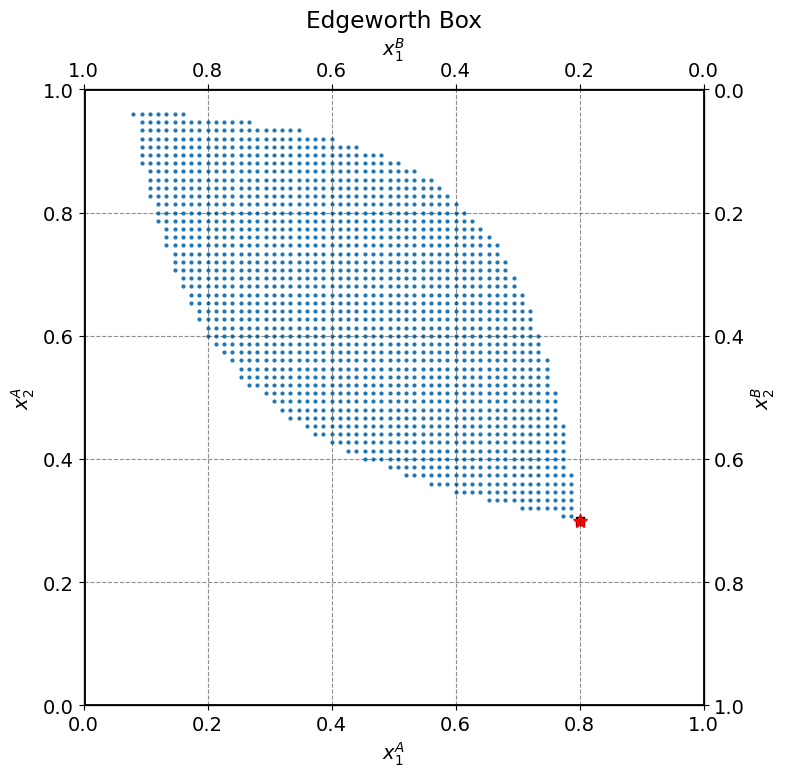

In [18]:
# creating an instance of the class
economy = ExchangeEconomyClass()
par = economy.par

# Compute initial utilities
initial_utility_A = economy.utility_A(par.w1A, par.w2A)
initial_utility_B = economy.utility_B(par.w1B, par.w2B)

# Parameters
N = 75
x1A_values = np.linspace(0, 1, N+1)
x2A_values = np.linspace(0, 1, N+1)

# Create arrays to store Pareto efficient allocations
pareto_efficient_allocations = []

# Iterate over all possible combinations of x1A and x2A
for x1A in x1A_values:
    for x2A in x2A_values:
        # Ensure x1B and x2B are non-negative
        x1B = 1 - x1A
        x2B = 1 - x2A
        if x1B >= 0 and x2B >= 0:
            # Compute utilities for the current allocation
            utility_A = economy.utility_A(x1A, x2A)
            utility_B = economy.utility_B(x1B, x2B)

            # Check if both utilities are at least as high as the initial endowment utilities
            if utility_A >= initial_utility_A and utility_B >= initial_utility_B:
                pareto_efficient_allocations.append((x1A, x2A))

# Convert the list of allocations to a NumPy array for plotting
pareto_efficient_allocations = np.array(pareto_efficient_allocations)

# Plot the Edgeworth box with the Pareto efficient allocations
fig = plt.figure(frameon=False, figsize=(8, 8), dpi=100)
ax_A = fig.add_subplot(1, 1, 1)

ax_A.set_xlabel("$x_1^A$")
ax_A.set_ylabel("$x_2^A$")

# Plot Pareto efficient allocations
ax_A.plot(pareto_efficient_allocations[:, 0], pareto_efficient_allocations[:, 1], 'o', markersize=2, label='Pareto Efficient Allocations')

# Plot initial endowments
ax_A.plot(par.w1A, par.w2A, 'r*', markersize=10, label='Initial Endowment A')
# ax_A.plot(par.w1B, par.w2B, 'b*', markersize=10, label='Initial Endowment B')

# A
ax_A.scatter(par.w1A,par.w2A,marker='s',color='black',label='endowment')

# limits
ax_A.plot([0, 1], [0, 0], lw=2, color='black')
ax_A.plot([0, 1], [1, 1], lw=2, color='black')
ax_A.plot([0, 0], [0, 1], lw=2, color='black')
ax_A.plot([1, 1], [0, 1], lw=2, color='black')

ax_A.set_xlim([0, 1])
ax_A.set_ylim([0, 1])
  
# Design for B
temp = ax_A.twinx()
temp.set_ylabel("$x_2^B$")
ax_B = temp.twiny()
ax_B.set_xlabel("$x_1^B$")
ax_B.invert_xaxis()
ax_B.invert_yaxis()
ax_B.set_xlim([1, 0])
ax_B.set_ylim([1, 0])

# Show the plot
plt.title('Edgeworth Box')
plt.grid(True)
John = plt.show()

The red star in the figure represents the initial endowment of the consumers, while the blue dots indicate Pareto-improving allocations. The two consumers have different preferences towards the two goods, determined by $\alpha$ and $\beta$. Consumer A prefers good 2 over good 1, and consumer B prefers good 1 over good 2. Both consumers have Cobb-Douglas utility functions, thus demanding positive amounts of both goods. Therefore, we get the cigar-shape of the Pareto-improvement allocations. 

# Question 2

For  $p_1 \in \mathcal{P}_1$ the excess demand in the market clearing condition, s, is shown in the figure below.

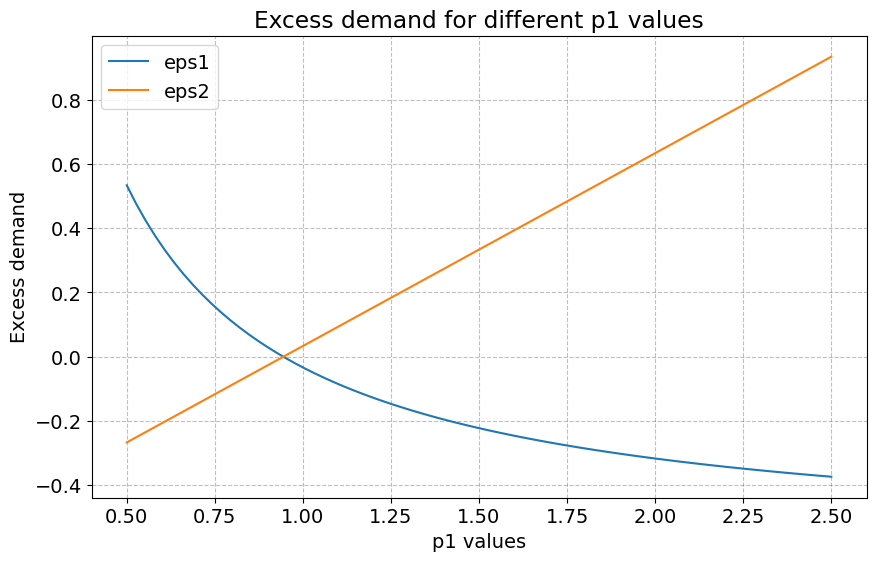

In [10]:
p1values = np.linspace(0.5, 2.5, N+1)
eps1_values = []
eps2_values = []

for p1 in p1values:
    eps1, eps2 = economy.check_market_clearing(p1)
    eps1_values.append(eps1)
    eps2_values.append(eps2)

# Plot the excess demand functions
plt.figure(figsize=(10, 6))
plt.plot(p1values, eps1_values, label='eps1')
plt.plot(p1values, eps2_values, label='eps2')
plt.xlabel('p1 values')
plt.ylabel('Excess demand')
plt.title('Excess demand for different p1 values')
plt.legend()
plt.show()

The figure illustrates that the excess demand equals zero at a $p_1$ value of approximately 0.9 (the exact market clearing price will be determined in the subsequent question). Furthermore, the orange line indicates that the excess demand for good 2 proportionally increases with the price of $p_1$. In contrast, the blue lines demonstrate that the excess demand for good 1 decreases as $p_1$ increases. 

For $\epsilon_2$: Changes in the price $p_1$ affect income but not the price of good 2. Therefore, any change in demand for good 2 is solely due to the income change caused by $p_1$.
For $\epsilon_1$: Changes in $p_1$ influence demand through both price and income effects. An increase in $p_1$ raises the price of good 1, reducing demand. However, this decrease is partially offset by the income increase resulting from selling the good.

# Question 3

In this question, we find the market clearing price with no excess demand, and further calculate the optimal allocations of consumers A and B for the two goods. 



In [11]:
def find_equilibrium(economy):
    # Define the excess demand function as a function of p1
    def excess_demand(p1):
        eps1, eps2 = economy.check_market_clearing(p1)
        return np.array([eps1, eps2])

    # Call the root finder
    result = minimize(lambda p1: np.sum(excess_demand(p1)**2), x0=1, method='Nelder-Mead', tol=1e-8)
    p1_star = result.x[0]
    return p1_star

print("The market clearing price is equal to: ", find_equilibrium(economy))

# We save the results, which will be presented in Exercise 6
Optimal_3_A = [economy.demand_A(find_equilibrium(economy))]
Optimal_3_B = [economy.demand_B(find_equilibrium(economy))]

# Convert the tuples in the lists to single lists
Optimal_3_A = [item for sublist in Optimal_3_A for item in sublist]
Optimal_3_B = [item for sublist in Optimal_3_B for item in sublist]

# Print the optimal allocations for consumer A and consumer B
print("Optimal allocation for consumer A for goods 1 and 2: ", Optimal_3_A)
print("Optimal allocation for consumer B for goods 1 and 2: ", Optimal_3_B)

The market clearing price is equal to:  0.9444444417953489
Optimal allocation for consumer A for goods 1 and 2:  [0.3725490199048352, 0.7037037022908529]
Optimal allocation for consumer B for goods 1 and 2:  [0.6274509817781195, 0.29629629611968994]


The market clearing price of 0.94 ensures that the excess demand for both goods equals zero, indicating full utilization of the initial endowment. This market clearing price matches the figure in Question 2.

# Question 4

__4a)__ In this exercise, we find the optimal allocation if only prices in $\mathcal{P}_1$ can be chosen. 



In [22]:
utility_values = []
optimal_allocations = []
N = 75
p1values = np.linspace(0.5, 2.5, N+1)
for p1 in p1values:
    x1B, x2B = economy.demand_B(p1)
    # Check if the allocation is feasible (non-negative for both A and B)
    if x1B >= 0 and x2B >= 0 and (1 - x1B) >= 0 and (1 - x2B) >= 0:
        # Utility of A given her allocation (the rest of the endowment)
        utility_A = economy.utility_A(1 - x1B, 1 - x2B)
        utility_values.append(utility_A)
        optimal_allocations.append((1 - x1B, 1 - x2B))
    else:
        # Append a very low utility value for non-feasible allocations
        utility_values.append(-np.inf)
        optimal_allocations.append((None, None))

# Find the index of the maximum utility value excluding non-feasible allocations
max_utility_index = np.argmax(utility_values)  # This will ignore -np.inf values
max_utility = utility_values[max_utility_index]
optimal_allocation_A = optimal_allocations[max_utility_index]
optimal_p1 = p1values[max_utility_index]

Optimal_4a_A = optimal_allocation_A
Optimal_4a_B = [1 - optimal_allocation_A[0], 1 - optimal_allocation_A[1]]

# Print the results
print("Optimal price p1:", optimal_p1)
print("Max utility for A:", max_utility)
print("Optimal allocation for A:", Optimal_4a_A)
print("Optimal allocation for B:", Optimal_4a_B)



Optimal price p1: 1.8866666666666667
Max utility for A: 0.633615985237553
Optimal allocation for A: (0.619316843345112, 0.6408888888888888)
Optimal allocation for B: [0.38068315665488806, 0.35911111111111116]


__4b)__ In this exercise, we find the optimal allocation when any positive price can be chosen.


In [13]:
def negative_utility_A(p1):
    # Get the demand for B given the price p1
    x1B, x2B = economy.demand_B(p1)
    
    # Calculate the remaining goods for A after B's consumption
    x1A_remaining = 1 - x1B
    x2A_remaining = 1 - x2B
    
    # The utility function for A expects positive consumption, if negative we return a large number
    if x1A_remaining < 0 or x2A_remaining < 0:
        return 1e6  # A large number to indicate a bad utility (not feasible)
    
    # Get the utility for A with the remaining goods
    utility_A = economy.utility_A(x1A_remaining, x2A_remaining)
    
    # We return the negative utility because we want to maximize the utility,
    # but the optimizer minimizes the function
    return -utility_A

# Find the price p1 that maximizes utility for A (minimizes the negative utility)
res = minimize_scalar(negative_utility_A, bounds=(0.00000, 15), method='bounded')

# The optimal price p1
optimal_p1 = res.x
optimal_utility = -res.fun  # We negate the fun value to get the actual utility

# Calculate the optimal allocations for A and B after optimization
x1B, x2B = economy.demand_B(optimal_p1)
x1A_remaining = 1 - x1B
x2A_remaining = 1 - x2B

# Print the results
print("Optimal price p1:", optimal_p1)
print("Max utility for A:", optimal_utility)
print("Optimal allocation for A:", (x1A_remaining, x2A_remaining))
print("Optimal allocation for B:", (x1B, x2B))


Optimal price p1: 1.8993465837364023
Max utility for A: 0.6336208506936581
Optimal allocation for A: (0.6209681350439451, 0.6400435610842399)
Optimal allocation for B: (0.3790318649560549, 0.3599564389157602)


In exercise 4a, the price $p_1$ is restricted by the set $\mathcal{P}_1$, which influences the optimal price and utility. The utility for A is slightly higher for any positive price in 4b, and the price is a bit higher. 

# Question 5

In Exercise 5, we assume that A chooses B’s consumption, ensuring that B is not worse off than in the initial endowment. A is thus the market maker.


__5a)__ In this exercise, we find the optimal allocation if the choice set is restricted to $\mathcal{C}$.

In [16]:
def results(economy):
    # Utility at endowment
    endowment_utility_A = economy.utility_A(economy.par.w1A, economy.par.w2A)
    endowment_utility_B = economy.utility_B(economy.par.w1B, economy.par.w2B)
    # Endowments
    endow_A = (economy.par.w1A, economy.par.w2A)
    endow_B = (economy.par.w1B, economy.par.w2B)
    # Optimal allocation
    optimal_allocation_A, max_util_A = economy.optimize_allocation()
    # We assume the final allocation for B is whatever is left after A's allocation
    final_allocation_B = (1-optimal_allocation_A[0], 1-optimal_allocation_A[1])
    # Utility for B at the final allocation
    final_utility_B = economy.utility_B(final_allocation_B[0], final_allocation_B[1])
    
    # Print results
    print(f"Utility for A at A's endowment: {endowment_utility_A}")
    print(f"Utility for B at B's endowment: {endowment_utility_B}")
    print(f"Endowment for A: {endow_A}")
    print(f"Endowment for B: {endow_B}")
    print(f"Optimal allocation for A: {optimal_allocation_A}")
    print(f"Max utility for A at optimal allocation: {max_util_A}")
    print(f"Final allocation for B: {final_allocation_B}")
    print(f"Utility for B at final allocation: {final_utility_B}")
    return optimal_allocation_A, max_util_A

# Call the results5b function with the results of the continuous optimization
results(economy)

Optimal_5A_A = [optimal_allocation_A[0], optimal_allocation_A[1]]
Optimal_5A_B = [1 - optimal_allocation_A[0], 1 - optimal_allocation_A[1]]

Utility for A at A's endowment: 0.41601676461038084
Utility for B at B's endowment: 0.30365889718756617
Endowment for A: (0.8, 0.3)
Endowment for B: (0.19999999999999996, 0.7)
Optimal allocation for A: (0.56, 0.8533333333333334)
Max utility for A at optimal allocation: 0.7415523509091093
Final allocation for B: (0.43999999999999995, 0.1466666666666666)
Utility for B at final allocation: 0.30507896071427915


In this exercise, consumer A chooses B's consumption, ensuring that B is not worse off than his initial endowment. We find that A is better off than in exercise 4 (a+b), which is as expected. Consumer A gets much higher utiliy at this allocation than his initial endowment, while consumer B gets almost the same utility compared to his initial endowment. 

5b) In this exercise, we find the optimal allocation if no further restrictions are imposed. 

In [ ]:
# code
# Define the utility of B at the endowment within the function
endowment_utility_B = economy.utility_B(economy.par.w1B, economy.par.w2B)

# Redefine the objective and constraints using the correct scope
def objective(x):
    return -economy.utility_A(x[0], x[1])

def constraint(x):
    return economy.utility_B(1-x[0], 1-x[1]) - endowment_utility_B

# Constraint dictionary
con = {'type': 'ineq', 'fun': constraint}

# Bounds for x1A and x2A (can't be negative or greater than total endowment)
bnds = ((0, 1), (0, 1))

# Initial guess (starting from A's endowment)
x0 = [economy.par.w1A, economy.par.w2A]

# Run the optimization again with the correct definition of endowment_utility_B in scope
solution = minimize(objective, x0, method='SLSQP', bounds=bnds, constraints=con)

# If the optimizer found a solution, extract it. Otherwise, set to None.
if solution.success:
    optimal_continuous_allocation_A = solution.x
    max_continuous_util_A = -solution.fun  # Negate because we minimized the negative utility
else:
    optimal_continuous_allocation_A = None
    max_continuous_util_A = None

optimal_continuous_allocation_A, max_continuous_util_A


def results5b(economy, optimal_allocation, max_utility):
    # Calculate initial utilities and endowments
    endowment_utility_A = economy.utility_A(economy.par.w1A, economy.par.w2A)
    endowment_utility_B = economy.utility_B(economy.par.w1B, economy.par.w2B)
    endow_A = (economy.par.w1A, economy.par.w2A)
    endow_B = (economy.par.w1B, economy.par.w2B)

    # Final utility and allocation for B based on A's optimal allocation
    final_allocation_B = (1 - optimal_allocation[0], 1 - optimal_allocation[1])
    final_utility_B = economy.utility_B(final_allocation_B[0], final_allocation_B[1])

    # Print results
    print(f"Initial utility for A: {endowment_utility_A}")
    print(f"Initial utility for B: {endowment_utility_B}")
    print(f"Initial endowment for A: {endow_A}")
    print(f"Initial endowment for B: {endow_B}")
    print(f"Optimal continuous allocation for A: {optimal_allocation}")
    print(f"Maximum continuous utility for A: {max_utility}")
    print(f"Final allocation for B: {final_allocation_B}")
    print(f"Final utility for B: {final_utility_B}")

# Call the results5b function with the results of the continuous optimization
results5b(economy, optimal_continuous_allocation_A, max_continuous_util_A)

Optimal_5B_A = [optimal_continuous_allocation_A[0], optimal_continuous_allocation_A[1]]
Optimal_5B_B = [1 - optimal_continuous_allocation_A[0], 1 - optimal_continuous_allocation_A[1]]


Initial utility for A: 0.41601676461038084
Initial utility for B: 0.30365889718756617
Initial endowment for A: (0.8, 0.3)
Initial endowment for B: (0.19999999999999996, 0.7)
Optimal continuous allocation for A: [0.57574506 0.84443779]
Maximum continuous utility for A: 0.7432276287140577
Final allocation for B: (0.42425494281286924, 0.15556221190083253)
Final utility for B: 0.3036588738576721


In this exercise, no restrictions are set on the choice set. We see that B's utility at this allocation is even lower and closer to his utility at the endowment, and A is even better off. 

# Question 6


__6a)__ Allocation with social planner

In [ ]:
# Objective function for the social planner
def objective_function(x):
    x1A, x2A, x1B, x2B = x
    return -(economy.utility_A(x1A, x2A) + economy.utility_B(x1B, x2B))

# Constraints for the optimization problem
def constraint1(x):
    return x[0] + x[2] - economy.par.w1A - economy.par.w1B

def constraint2(x):
    return x[1] + x[3] - economy.par.w2A - economy.par.w2B

# Initial guess for consumption allocations
x0 = [0.5, 0.5, 0.5, 0.5]  

# Bounds for consumption allocations (non-negative consumption)
bounds = [(0, None)] * 4  # Bounds for each variable

# Defining the constraints
cons = [{'type': 'eq', 'fun': constraint1}, {'type': 'eq', 'fun': constraint2}]

# Solving the optimization problem
result = minimize(objective_function, x0, bounds=bounds, constraints=cons)

# Extracting the optimal allocation
optimal_allocation = result.x

print("Optimal allocation:")
print("x1A:", optimal_allocation[0])
print("x2A:", optimal_allocation[1])
print("x1B:", optimal_allocation[2])
print("x2B:", optimal_allocation[3])

Optimal allocation:
x1A: 0.3333333432674408
x2A: 0.6666666641831397
x1B: 0.6666666567325592
x2B: 0.3333333358168603


When a utilitarian social planner aims to maximize aggregate utility, we find that the optimal allocation directly mirrors each consumers' preferences for the two goods, $\alpha$ and $\beta$. The results are further described in exercise 6b. 

__6b)__ Illustration and comparison with previous questions

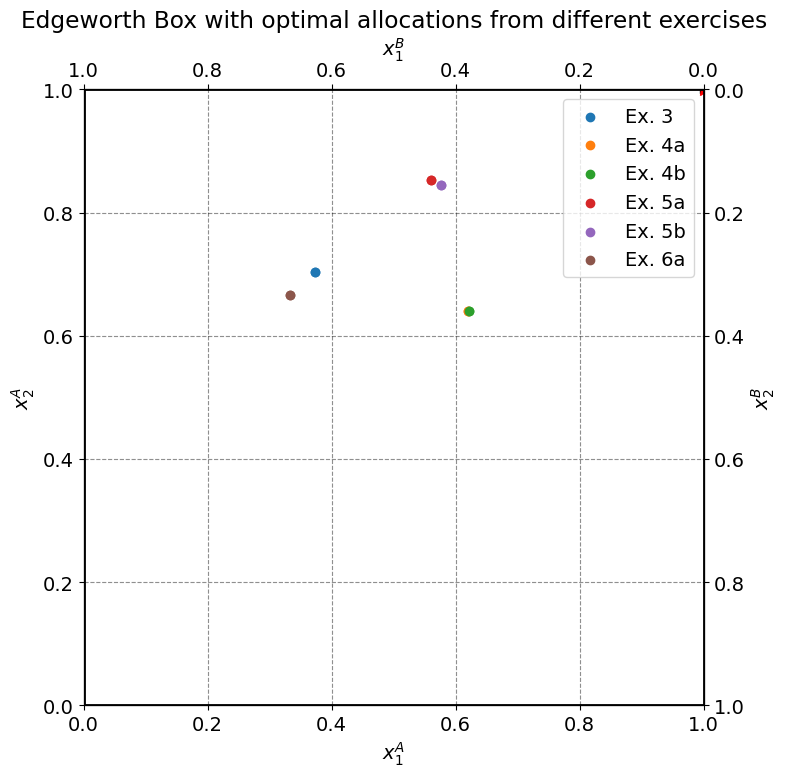

  Allocation  Utility A  Utility B  Sum of Utilities
0      Ex. 3   0.569274   0.488610          1.057883
1     Ex. 4a   0.633616   0.373352          1.006968
2     Ex. 4b   0.633621   0.372564          1.006184
3     Ex. 5a   0.741552   0.305079          1.046631
4     Ex. 5b   0.743228   0.303659          1.046887
5     Ex. 6a   0.529134   0.529134          1.058267


In [ ]:
# Define the optimal allocations
allocations_A = [(0.3725490199048352, 0.7037037022908529), (0.619316843345112, 0.6408888888888888), (0.6209681350439451, 0.6400435610842399), (0.56, 0.8533333333333334), (0.57574506, 0.84443779), (0.3333333432674408, 0.6666666641831397)]
allocations_B = [(0.6274509817781195, 0.29629629611968994), (0.380683156654888, 0.3591111111111112), (0.3790318649560549, 0.3599564389157602), (0.44, 0.14666666666666656), (0.42425494281286924, 0.15556221190083253), (0.6666666567325592, 0.3333333358168603)]

# Define the labels
labels = ['Ex. 3', 'Ex. 4a', 'Ex. 4b', 'Ex. 5a', 'Ex. 5b', 'Ex. 6a']

# Plot the Edgeworth box with the Pareto efficient allocations
fig = plt.figure(frameon=False, figsize=(8, 8), dpi=100)
ax_A = fig.add_subplot(1, 1, 1)

ax_A.set_xlabel("$x_1^A$")
ax_A.set_ylabel("$x_2^A$")

# Plot Pareto efficient allocations
for allocation_A, label in zip(allocations_A, labels):
    ax_A.scatter(*allocation_A, label=label)

# Plot initial endowments
ax_A.plot(1, 1, 'r*', markersize=10, label='Initial Endowment A')

# A
ax_A.scatter(1, 1, marker='s', color='black', label='endowment')

# limits
ax_A.plot([0, 1], [0, 0], lw=2, color='black')
ax_A.plot([0, 1], [1, 1], lw=2, color='black')
ax_A.plot([0, 0], [0, 1], lw=2, color='black')
ax_A.plot([1, 1], [0, 1], lw=2, color='black')

ax_A.set_xlim([0, 1])
ax_A.set_ylim([0, 1])

# Design for B
temp = ax_A.twinx()
temp.set_ylabel("$x_2^B$")
ax_B = temp.twiny()
ax_B.set_xlabel("$x_1^B$")
ax_B.invert_xaxis()
ax_B.invert_yaxis()
ax_B.set_xlim([1, 0])
ax_B.set_ylim([1, 0])

# Plot Pareto efficient allocations for B
for allocations_B, label in zip(allocations_B, labels):
    ax_B.scatter(*allocations_B, label=label)

# Show the plot
plt.title('Edgeworth Box with optimal allocations from different exercises')
plt.legend()
plt.grid(True)
plt.show()

allocations_A = [(0.3725490199048352, 0.7037037022908529), (0.619316843345112, 0.6408888888888888), (0.6209681350439451, 0.6400435610842399), (0.56, 0.8533333333333334), (0.57574506, 0.84443779), (0.3333333432674408, 0.6666666641831397)]
allocations_B = [(0.6274509817781195, 0.29629629611968994), (0.380683156654888, 0.3591111111111112), (0.3790318649560549, 0.3599564389157602), (0.44, 0.14666666666666656), (0.42425494281286924, 0.15556221190083253), (0.6666666567325592, 0.3333333358168603)]

# Define the utility functions
def utility_A(x1A, x2A, alpha=1/3):
    return x1A**alpha * x2A**(1-alpha)

def utility_B(x1B, x2B, beta=2/3):
    return x1B**beta * x2B**(1-beta)

# Calculate the utilities for each allocation
utilities_A = [utility_A(x1A, x2A) for x1A, x2A in allocations_A]
utilities_B = [utility_B(x1B, x2B) for x1B, x2B in allocations_B]

# Calculate the sum of utilities for A and B
utilities_sum = [uA + uB for uA, uB in zip(utilities_A, utilities_B)]

# Create a DataFrame
df = pd.DataFrame({
    'Allocation': labels,
    'Utility A': utilities_A,
    'Utility B': utilities_B,
    'Sum of Utilities': utilities_sum
})

print(df)

In the Edgeworth box above, all the optimal allocations from exercise 3)-6) are plotted. Note that the allocations for Ex. 4a and 4b are very close to eachother, which makes it difficult to see the difference. Furthermore, a table of the allocations and the respective utilities are shown. Here we see that the total utility is highest when the utilitarian social planner chooses the allocation, which is in line with theory (maximized aggregate utility). We see in Exercise 4 and 5 that utility is higher for consumer A than B, due to the fact that A chooses the price $p_1$ to maximize his own utility, given some restrictions for consumer B. The allocations without restrictions makes consumer A even better off. 

# Question 7 + 8

In Exercises 7 and 8, we draw a set W with 50 elements, find the market equilibrium allocation for each ωA ∈ C, and plot them in the Edgeworth box.

Set, $\mathcal{W}$, drawn with 50 elements

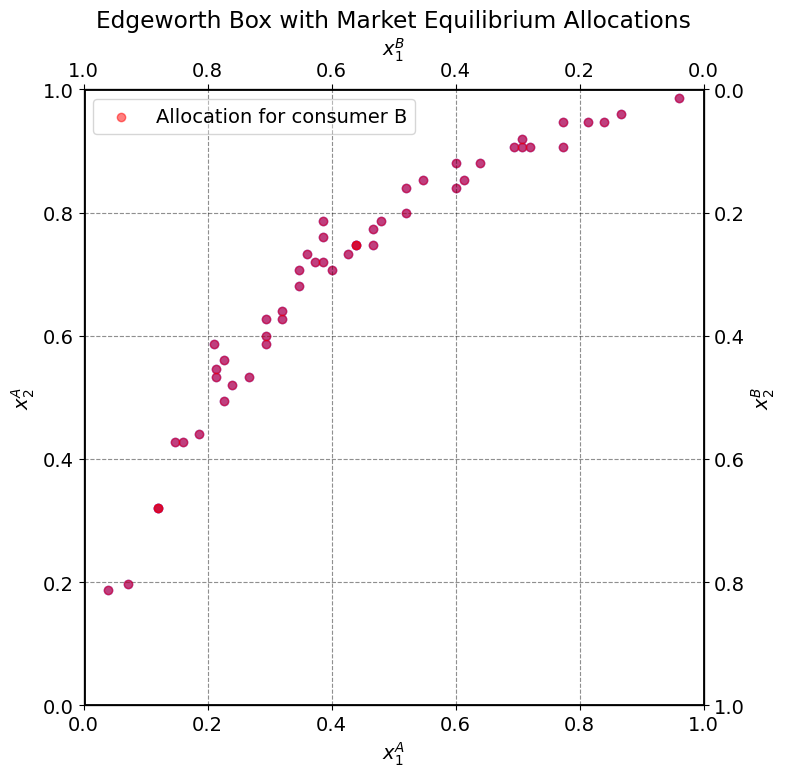

In [ ]:
# Generate a random set W with 50 elements
np.random.seed(0)
num_elements = 50
w1A_values = np.random.uniform(0, 1, num_elements)
w2A_values = np.random.uniform(0, 1, num_elements)

# Initialize matplotlib plot for the Edgeworth box
fig = plt.figure(frameon=False, figsize=(8, 8), dpi=100)
ax_A = fig.add_subplot(1, 1, 1)

ax_A.set_xlabel("$x_1^A$")
ax_A.set_ylabel("$x_2^A$")

# limits
ax_A.plot([0, 1], [0, 0], lw=2, color='black')
ax_A.plot([0, 1], [1, 1], lw=2, color='black')
ax_A.plot([0, 0], [0, 1], lw=2, color='black')
ax_A.plot([1, 1], [0, 1], lw=2, color='black')

ax_A.set_xlim([0, 1])
ax_A.set_ylim([0, 1])

# Design for B
temp = ax_A.twinx()
temp.set_ylabel("$x_2^B$")
ax_B = temp.twiny()
ax_B.set_xlabel("$x_1^B$")
ax_B.invert_xaxis()
ax_B.invert_yaxis()
ax_B.set_xlim([1, 0])
ax_B.set_ylim([1, 0])

# Find market equilibrium allocations and plot them
for w1A, w2A in zip(w1A_values, w2A_values):
    # Update the economy's endowments based on the random set W
    economy.par.w1A, economy.par.w2A = w1A, w2A
    economy.par.w1B, economy.par.w2B = 1 - w1A, 1 - w2A
    
    # Use the optimize_allocation method to find the optimal allocation
    optimal_allocation_A, max_util_A = economy.optimize_allocation()
    
    x1A, x2A = optimal_allocation_A
    x1B, x2B = 1 - x1A, 1 - x2A  # Allocate the remainder to B

    # Plot A's and B's allocations
    ax_A.scatter(x1A, x2A, color='blue', label='Allocation A' if w1A == w1A_values[0] else "", alpha=0.5)
    ax_B.scatter(x1B, x2B, color='red', label='Allocation for consumer B' if w1A == w1A_values[0] else "", alpha=0.5)

# Simplify the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax_A.legend(by_label.values(), by_label.keys())

plt.title('Edgeworth Box with Market Equilibrium Allocations')
plt.grid(True)
plt.show()

In the above figure, we have plotted the market equilibrium allocation for each $\omega^A \in \mathcal{C}$ in the Edgeworth box. We find that the market solutions at the different random endowments mirror the contract curve. This is due to the fact that the Edgeworth box represents all possible Pareto-efficient allocations given the initial endowments of agents A and B. As we vary $\omega^A$, the points representing equilibrium allocations move along the contract curve, illustrating how different distributions of initial endowments affect the final allocations achievable through trade. This visual representation helps us understand the efficiency of market outcomes under varying initial conditions.